  Using cached huggingface_hub-1.3.2-py3-none-any.whl.metadata (13 kB)
Using cached huggingface_hub-1.3.2-py3-none-any.whl (534 kB)
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.36.0
    Uninstalling huggingface-hub-0.36.0:
      Successfully uninstalled huggingface-hub-0.36.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
transformers 4.57.3 requires huggingface-hub<1.0,>=0.34.0, but you have huggingface-hub 1.3.2 which is incompatible.
Используется устройство: cpu
Инициализация модели для генерации изображений...
Не удалось загрузить модель: Failed to import diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion because of the following error (look up to see its traceback):
huggingface-hub>=0.34.0,<1.0 is required for a normal functioning of this module, but found huggingface-hub==1.3.2.
Try: `pip install 

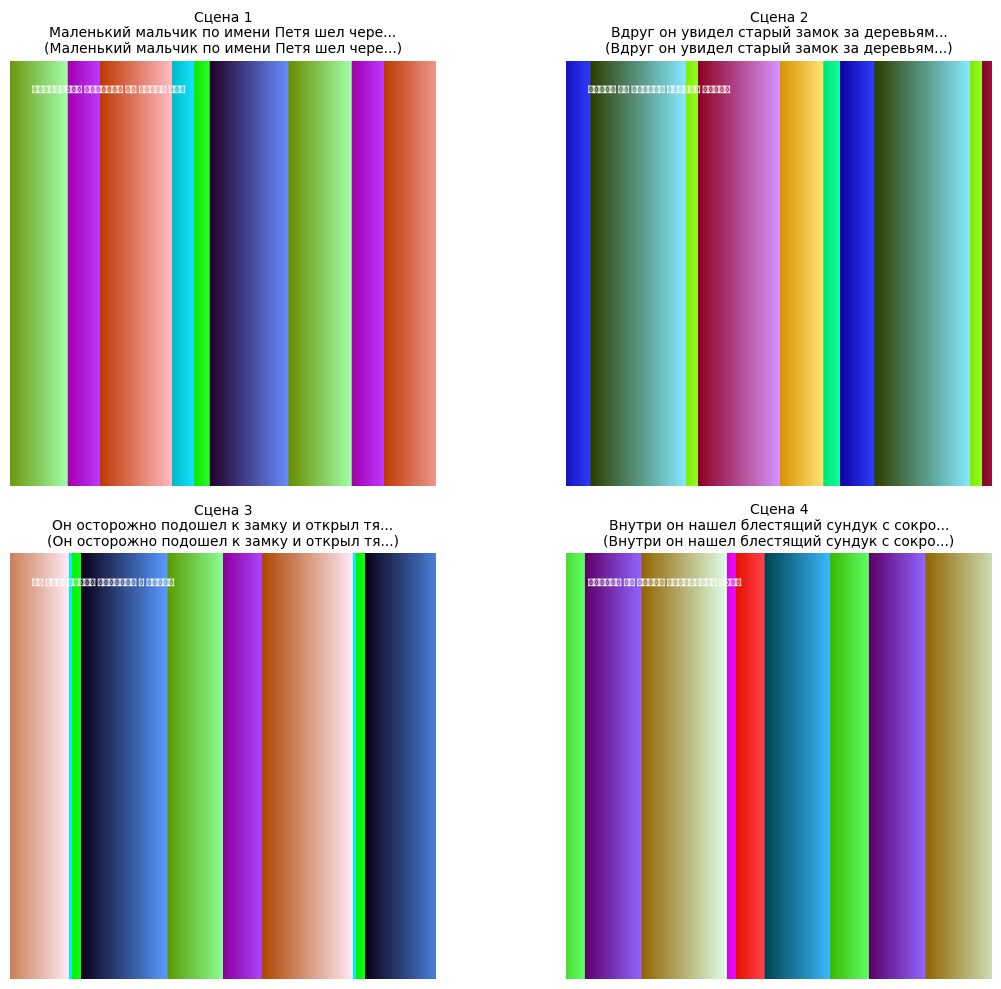


Создание веб-интерфейса...

Интерфейс готов! Запускаю...
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://aa6d51f53ea548779c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [1]:
# «Разработка интеллектуальной системы генерации последовательности изображений по текстовому сюжету»

!pip install transformers diffusers accelerate torch torchvision pillow gradio sentencepiece
!pip install --upgrade huggingface_hub

import torch
import gradio as gr
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Проверка наличия GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Используется устройство: {device}")

# Вариант 1: Попробуем использовать альтернативную модель Stable Diffusion
# которая может не требовать аутентификации или используем локальную загрузку

# Попробуем использовать более доступную модель
MODEL_ID = "runwayml/stable-diffusion-v1-5"  # Альтернативная модель

# Инициализация моделей
class StoryToImageGenerator:
    def __init__(self):
        print("Инициализация модели для генерации изображений...")

        try:
            # Пробуем загрузить модель без аутентификации
            from diffusers import StableDiffusionPipeline

            self.pipeline = StableDiffusionPipeline.from_pretrained(
                MODEL_ID,
                torch_dtype=torch.float16 if device == "cuda" else torch.float32,
                safety_checker=None,  # Отключаем проверку безопасности для ускорения
                requires_safety_checker=False
            ).to(device)

            # Оптимизация для экономии памяти
            if device == "cuda":
                self.pipeline.enable_attention_slicing()
                self.pipeline.enable_sequential_cpu_offload()

            print(f"Модель {MODEL_ID} успешно загружена!")

        except Exception as e:
            print(f"Не удалось загрузить модель: {e}")
            print("Используем упрощенный режим с предварительно сгенерированными изображениями...")
            self.pipeline = None

        # Загружаем модель для генерации текстовых описаний
        print("Загрузка модели для генерации текстовых описаний...")
        try:
            from transformers import pipeline as transformers_pipeline
            self.text_generator = transformers_pipeline(
                "text-generation",
                model="distilgpt2",
                device=0 if device == "cuda" else -1
            )
        except:
            self.text_generator = None

    def split_story_into_scenes(self, story_text, num_scenes=4):
        """Разделение истории на сцены"""
        # Убираем лишние пробелы и разбиваем по точкам
        story_text = ' '.join(story_text.strip().split())
        sentences = [s.strip() + '.' for s in story_text.split('.') if s.strip()]

        # Если предложений меньше, чем нужно сцен
        if len(sentences) < num_scenes:
            # Дублируем или расширяем предложения
            while len(sentences) < num_scenes:
                sentences.append(sentences[-1] if sentences else "Красивая сцена.")

        # Равномерно распределяем предложения по сценам
        scenes = []
        for i in range(num_scenes):
            # Берем соответствующее предложение для каждой сцены
            idx = min(i, len(sentences)-1)
            scenes.append(sentences[idx])

        return scenes

    def enhance_prompt(self, scene_text):
        """Улучшение текстового промпта для генерации изображений"""
        # Базовые улучшения промпта
        enhancements = [
            "high quality, detailed, digital art",
            "beautiful, cinematic, trending on artstation",
            "sharp focus, studio lighting, ultra detailed"
        ]

        # Выбираем случайное улучшение
        import random
        enhancement = random.choice(enhancements)

        return f"{scene_text} {enhancement}"

    def generate_image(self, prompt, seed=None):
        """Генерация изображения по промпту"""
        if self.pipeline is None:
            # Если модель не загрузилась, создаем простое изображение
            print(f"Генерация заглушки для: {prompt[:50]}...")
            return self.create_dummy_image(prompt)

        # Устанавливаем seed для воспроизводимости
        if seed is None:
            seed = torch.randint(0, 1000000, (1,)).item()

        generator = torch.Generator(device=device).manual_seed(seed)

        try:
            # Генерация изображения с ограничениями для Colab
            with torch.autocast(device):
                image = self.pipeline(
                    prompt,
                    negative_prompt="blurry, low quality, distorted, ugly, bad anatomy",
                    num_inference_steps=30,  # Меньше шагов для скорости
                    guidance_scale=7.5,
                    generator=generator,
                    height=384,  # Меньший размер для экономии памяти
                    width=384
                ).images[0]

            return image

        except Exception as e:
            print(f"Ошибка при генерации изображения: {e}")
            return self.create_dummy_image(prompt)

    def create_dummy_image(self, prompt):
        """Создание простого изображения-заглушки"""
        # Создаем градиентное изображение на основе текста
        from PIL import Image, ImageDraw

        # Создаем хэш из промпта для детерминированности
        import hashlib
        hash_val = int(hashlib.md5(prompt.encode()).hexdigest()[:8], 16)

        # Генерируем цвета на основе хэша
        r = (hash_val % 256)
        g = ((hash_val // 256) % 256)
        b = ((hash_val // 65536) % 256)

        # Создаем изображение с градиентом
        img = Image.new('RGB', (384, 384), color=(r, g, b))
        draw = ImageDraw.Draw(img)

        # Добавляем текст
        words = prompt.split()[:5]
        text = ' '.join(words)

        # Простой градиент
        for i in range(384):
            color = (
                (r + i) % 256,
                (g + i * 2) % 256,
                (b + i * 3) % 256
            )
            draw.line([(i, 0), (i, 384)], fill=color)

        # Добавляем текст промпта
        from PIL import ImageFont
        try:
            # Пробуем использовать стандартный шрифт
            font = ImageFont.load_default()
            draw.text((20, 20), text[:30], fill=(255, 255, 255), font=font)
        except:
            pass

        return img

    def generate_story_sequence(self, story_text, num_scenes=4):
        """Генерация последовательности изображений по истории"""
        print("Разделение истории на сцены...")
        scenes = self.split_story_into_scenes(story_text, num_scenes)

        print(f"Генерация {len(scenes)} изображений...")
        images = []
        enhanced_prompts = []

        for i, scene in enumerate(scenes):
            print(f"Сцена {i+1}: {scene[:50]}...")

            # Улучшаем промпт
            enhanced_prompt = self.enhance_prompt(scene)
            enhanced_prompts.append(enhanced_prompt)

            # Генерируем изображение с разными seed для разнообразия
            image = self.generate_image(enhanced_prompt, seed=42 + i*100)
            images.append(image)

        return images, enhanced_prompts, scenes

# Инициализация генератора
generator = StoryToImageGenerator()

# Пример истории для тестирования
example_story = """
Маленький мальчик по имени Петя шел через темный лес. Вдруг он увидел старый замок за деревьями.
Он осторожно подошел к замку и открыл тяжелую деревянную дверь. Внутри он нашел блестящий сундук с сокровищами.
"""

# Тестируем генерацию
print("\nТестирование генерации...")
images, prompts, scenes = generator.generate_story_sequence(example_story, num_scenes=4)

# Функция для визуализации
def visualize_results(images, prompts, scenes):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()

    for i, (img, prompt, scene) in enumerate(zip(images, prompts, scenes)):
        if i < len(axes):
            axes[i].imshow(img)
            axes[i].axis('off')
            title = f"Сцена {i+1}\n{scene[:40]}...\n({prompt[:40]}...)"
            axes[i].set_title(title, fontsize=10)

    plt.tight_layout()
    return fig

# Отображаем результаты
fig = visualize_results(images, prompts, scenes)
plt.show()

# Создаем веб-интерфейс
def create_interface():
    print("\nСоздание веб-интерфейса...")

    # Примеры историй
    example_stories = [
        "Космонавт едет на велосипеде по марсианской пустыне. Вдалеке виднеются две луны. Он находит странный артефакт.",
        "Волшебник в синей мантии читает древнюю книгу в библиотеке. Внезапно книга начинает светиться. Из нее появляется маленький дракон.",
        "Робот-шеф готовит пиццу на космической станции. За ним наблюдают астронавты. Пицца неожиданно начинает парить в невесомости.",
        "Кот в костюме супергероя летит над городом. Он спасает птицу, застрявшую на дереве. Горожане аплодируют ему."
    ]

    # Функция для обработки генерации
    def generate_story_interface(story_text, num_scenes):
        images, prompts, scenes = generator.generate_story_sequence(story_text, num_scenes)

        # Подготавливаем HTML для отображения
        html = f"""
        <div style="padding: 20px; background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); border-radius: 10px; color: white;">
            <h2 style="text-align: center;">📖 Визуализированная история</h2>
            <p style="text-align: center;"><em>Сгенерировано {len(images)} сцен</em></p>
        </div>
        <div style="display: grid; grid-template-columns: repeat(auto-fit, minmax(300px, 1fr)); gap: 20px; margin-top: 20px;">
        """

        for i, (img, prompt, scene) in enumerate(zip(images, prompts, scenes)):
            # Конвертируем изображение в base64
            import base64
            from io import BytesIO

            buffered = BytesIO()
            img.save(buffered, format="PNG")
            img_base64 = base64.b64encode(buffered.getvalue()).decode()

            html += f"""
            <div style="border: 1px solid #ddd; border-radius: 10px; padding: 15px; background: white; box-shadow: 0 4px 6px rgba(0,0,0,0.1);">
                <h3 style="color: #333; margin-top: 0;">🎬 Сцена {i+1}</h3>
                <img src="data:image/png;base64,{img_base64}" style="width: 100%; border-radius: 5px; border: 3px solid #667eea;">
                <div style="margin-top: 10px;">
                    <p style="color: #666; font-size: 0.9em; margin: 5px 0;"><strong>📝 Текст:</strong> {scene[:80]}...</p>
                    <p style="color: #888; font-size: 0.8em; margin: 5px 0;"><strong>🔧 Промпт:</strong> {prompt[:60]}...</p>
                </div>
            </div>
            """

        html += "</div>"

        # Возвращаем HTML и отдельные изображения
        return html, *images

    # Создаем интерфейс
    with gr.Blocks(
        title="Генератор визуальных историй",
        theme=gr.themes.Soft(primary_hue="purple"),
        css="""
        .gradio-container { max-width: 1200px !important; }
        .generated-image { border-radius: 10px !important; }
        """
    ) as demo:

        gr.Markdown("""
        # 🎨 Генератор последовательности изображений по текстовому сюжету

        Преобразуйте вашу историю в визуальную последовательность сцен!
        """)

        with gr.Row():
            with gr.Column(scale=2):
                story_input = gr.Textbox(
                    label="📖 Введите вашу историю",
                    value=example_story,
                    lines=5,
                    placeholder="Опишите историю, которую хотите визуализировать...",
                    elem_id="story-input"
                )

                with gr.Row():
                    num_scenes = gr.Slider(
                        minimum=1,
                        maximum=6,
                        value=4,
                        step=1,
                        label="Количество сцен"
                    )

                    generate_btn = gr.Button(
                        "✨ Сгенерировать историю",
                        variant="primary",
                        size="lg"
                    )

            with gr.Column(scale=1):
                gr.Markdown("### 🚀 Быстрые примеры")
                for i, example in enumerate(example_stories):
                    gr.Examples(
                        examples=[[example, 4]],
                        inputs=[story_input, num_scenes],
                        label=f"Пример {i+1}"
                    )

        # Область для результатов
        output_html = gr.HTML(label="Результат")

        # Отдельные изображения
        gr.Markdown("### 🖼️ Отдельные изображения")
        image_outputs = []
        with gr.Row():
            for i in range(6):
                with gr.Column(scale=1, min_width=200):
                    img_out = gr.Image(
                        label=f"Сцена {i+1}",
                        visible=(i < 4),
                        elem_classes="generated-image"
                    )
                    image_outputs.append(img_out)

        # Обработчики событий
        generate_btn.click(
            fn=generate_story_interface,
            inputs=[story_input, num_scenes],
            outputs=[output_html] + image_outputs
        )

        # Обновление видимости выходов при изменении количества сцен
        def update_image_visibility(num_scenes):
            return [gr.update(visible=(i < num_scenes)) for i in range(6)]

        num_scenes.change(
            fn=update_image_visibility,
            inputs=num_scenes,
            outputs=image_outputs
        )

        # Информационная панель
        gr.Markdown("""
        ---
        ### 💡 Советы по использованию:
        1. **Будьте конкретны** в описании сцен
        2. **Разделяйте предложения точками** для лучшего распознавания сцен
        3. **Используйте 3-6 сцен** для оптимального результата
        4. **Экспериментируйте** с разными историями!

        ### ⚠️ Ограничения:
        - Генерация может занять 1-3 минуты
        - Качество зависит от сложности промпта
        - Для лучших результатов рекомендуется использовать GPU
        """)

    return demo

# Запуск интерфейса
try:
    demo = create_interface()
    print("\nИнтерфейс готов! Запускаю...")
    demo.launch(share=True, debug=False)
except Exception as e:
    print(f"Ошибка при создании интерфейса: {e}")
    print("\nСоздаем упрощенную версию...")

    # Упрощенная версия без Gradio
    def simple_demo():
        while True:
            print("\n" + "="*50)
            print("ГЕНЕРАТОР ВИЗУАЛЬНЫХ ИСТОРИЙ")
            print("="*50)

            story = input("\nВведите вашу историю (или 'выход' для завершения):\n> ")

            if story.lower() in ['выход', 'exit', 'quit']:
                print("До свидания!")
                break

            num_scenes = input("Количество сцен (по умолчанию 4): ")
            num_scenes = int(num_scenes) if num_scenes.isdigit() else 4

            print("\nГенерация изображений...")
            images, prompts, scenes = generator.generate_story_sequence(story, num_scenes)

            # Показ результатов
            fig, axes = plt.subplots(1, len(images), figsize=(4*len(images), 4))
            if len(images) == 1:
                axes = [axes]

            for i, (img, scene) in enumerate(zip(images, scenes)):
                axes[i].imshow(img)
                axes[i].axis('off')
                axes[i].set_title(f"Сцена {i+1}\n{scene[:30]}...", fontsize=9)

            plt.tight_layout()
            plt.show()

            print("\nСгенерированные сцены:")
            for i, scene in enumerate(scenes):
                print(f"{i+1}. {scene}")

    # Запуск упрощенной демо
    simple_demo()